**Домашнее задание к занятию «Сингулярный спектральный анализ»**

Проведите анализ с помощью SSA в любом из временных рядов с первого занятия.
При желании можете воспользоваться своим временным рядом — работа, Kaggle и т. д.

In [118]:
# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statistics as st

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 8
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [97]:
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

In [98]:
# Возьмём данные отсюда:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [99]:
climate = pd.read_csv('DailyDelhiClimateTrain.csv').dropna()
climate

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [100]:
series = climate['meantemp']
series

0       10.000000
1        7.400000
2        7.166667
3        8.666667
4        6.000000
          ...    
1457    17.217391
1458    15.238095
1459    14.095238
1460    15.052632
1461    10.000000
Name: meantemp, Length: 1462, dtype: float64

Text(0.5, 1.0, 'Climate Time Series: Average Tempreture')

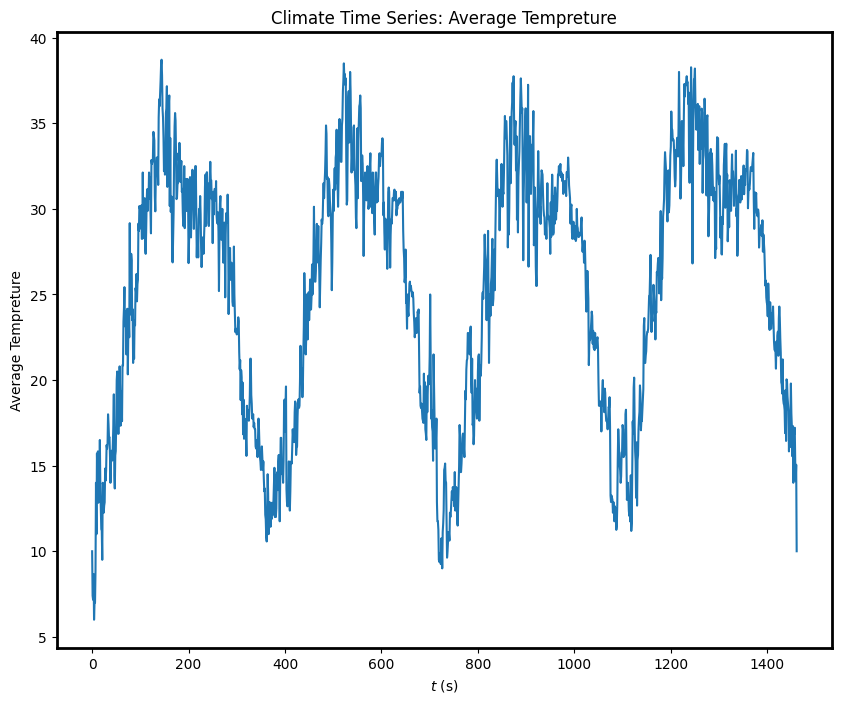

In [101]:
series.plot()
plt.xlabel(r'$t$ (s)')
plt.ylabel('Average Tempreture')
plt.title('Climate Time Series: Average Tempreture')

In [102]:
# Установим несколько вариантов длины окна исходя из 2≤𝐿≤𝑁/2
# и найдём компоненты

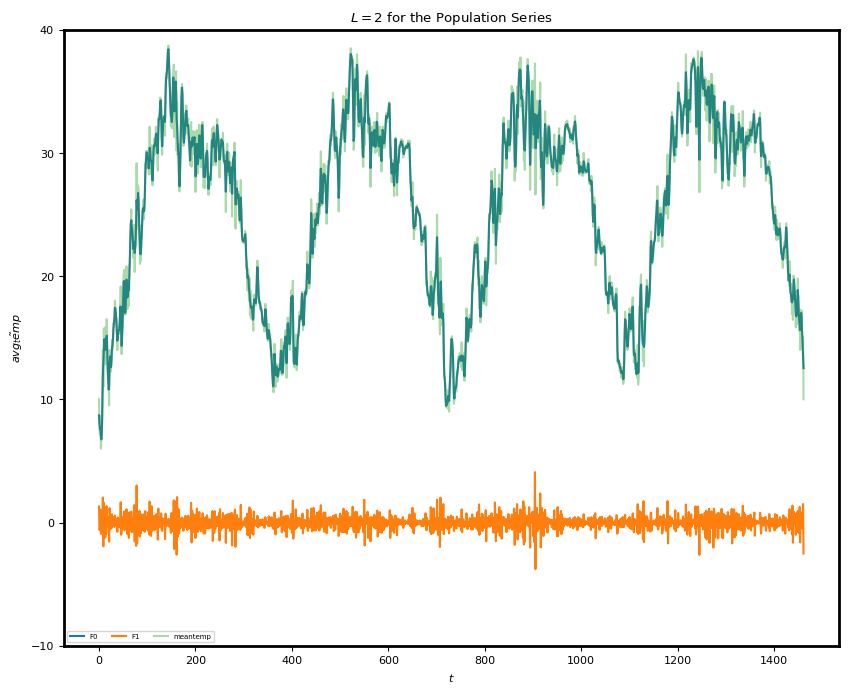

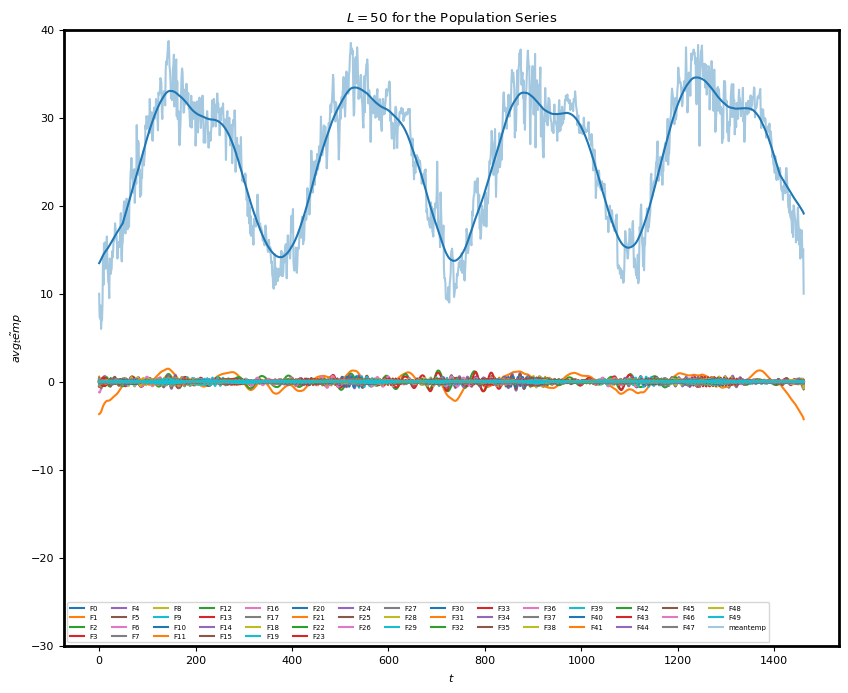

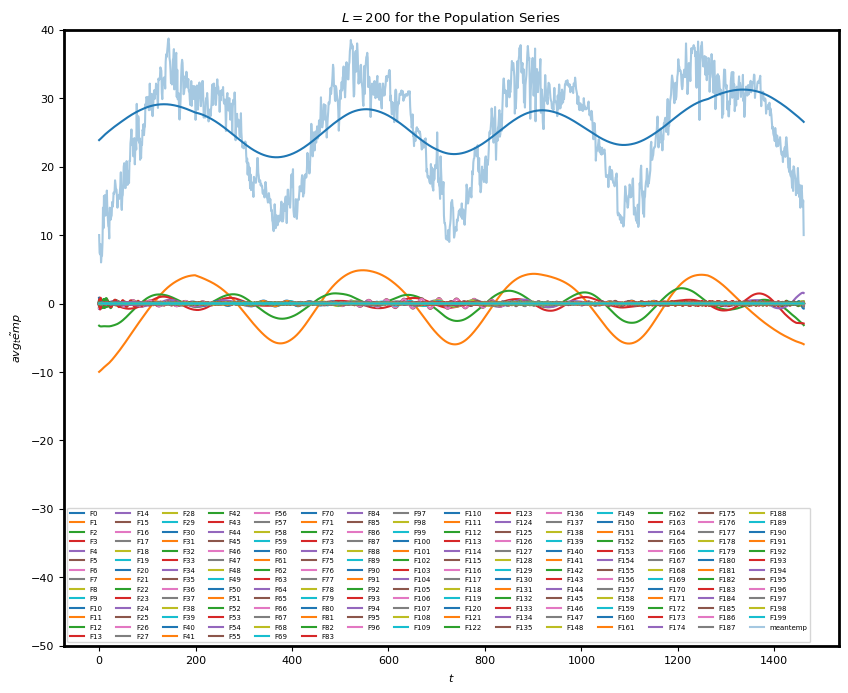

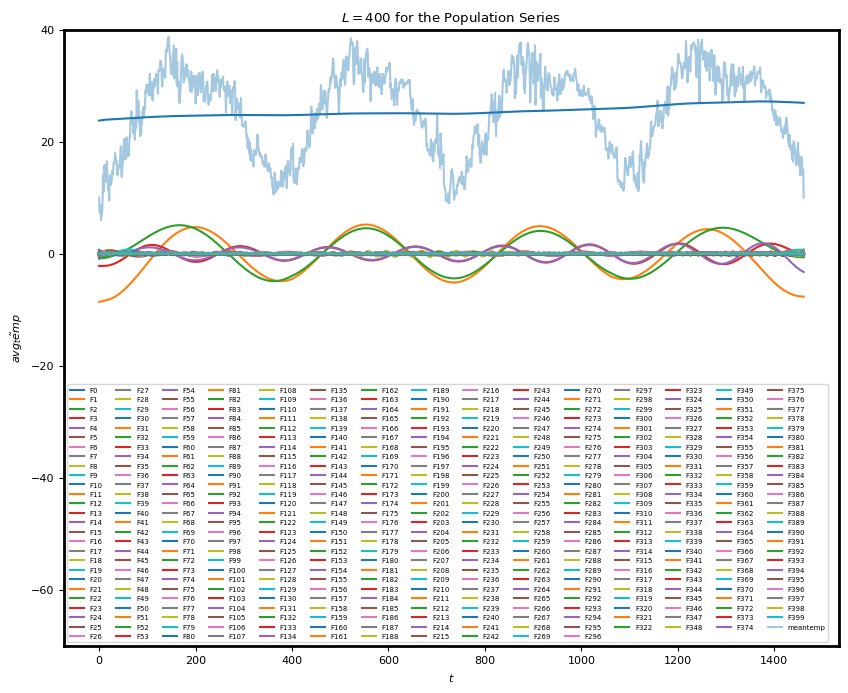

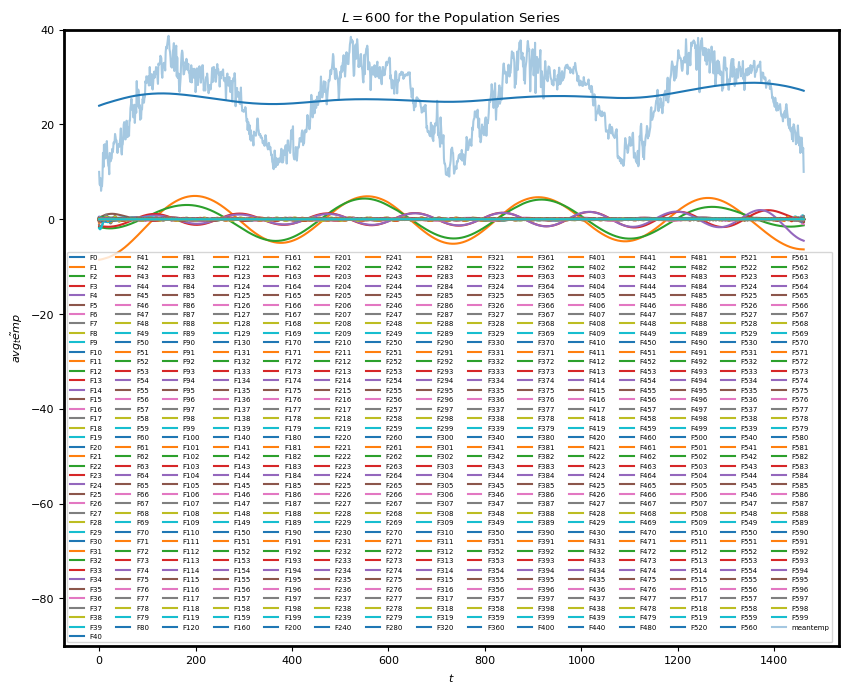

In [129]:
L = [2, 50, 200, 400, 600]
lim = -10
for l in L:
  T_ssa = SSA(series, l)
  T_ssa.components_to_df().plot()
  T_ssa.orig_TS.plot(alpha=0.4)
  plt.xlabel('$t$')
  plt.ylabel(r'$\tilde{avg_temp}$')
  plt.ylim(lim, 40)
  plt.legend(loc = 'lower left', ncol = 15, fontsize = 5)
  plt.title(f'$L={l}$ for the Population Series')
  lim -= 20

In [104]:
# На графике с размером окна = 400 компоненты ряда выделены лучше всего:
# - компонента F0 отслеживает тренд
# - компоненты F1, F2 отслеживают сезонность 1
# - компоненты  F3, F4 отслеживают сезонность 2

In [105]:
# Построим матрицу корреляций

Text(0.5, 1.0, 'W-Correlation for Climate Time Series, $L=400$')

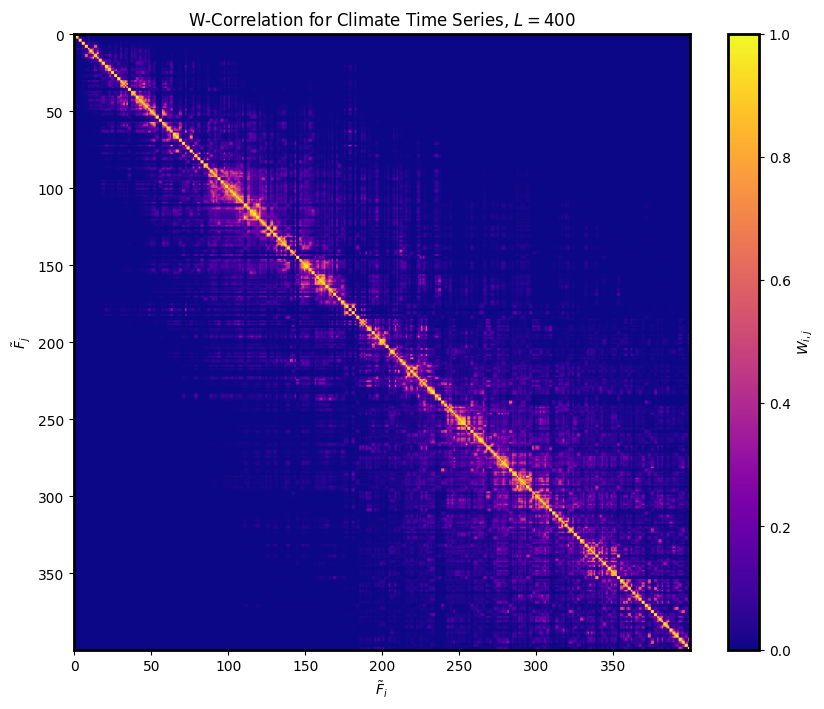

In [106]:
from pandas.core.arrays.numeric import T
T_ssa = SSA(series, 400)
T_ssa.plot_wcorr()
plt.title("W-Correlation for Climate Time Series, $L=400$")

Text(0.5, 1.0, 'W-Correlation for Climate Time Series, $L=400$, (first 30 components)')

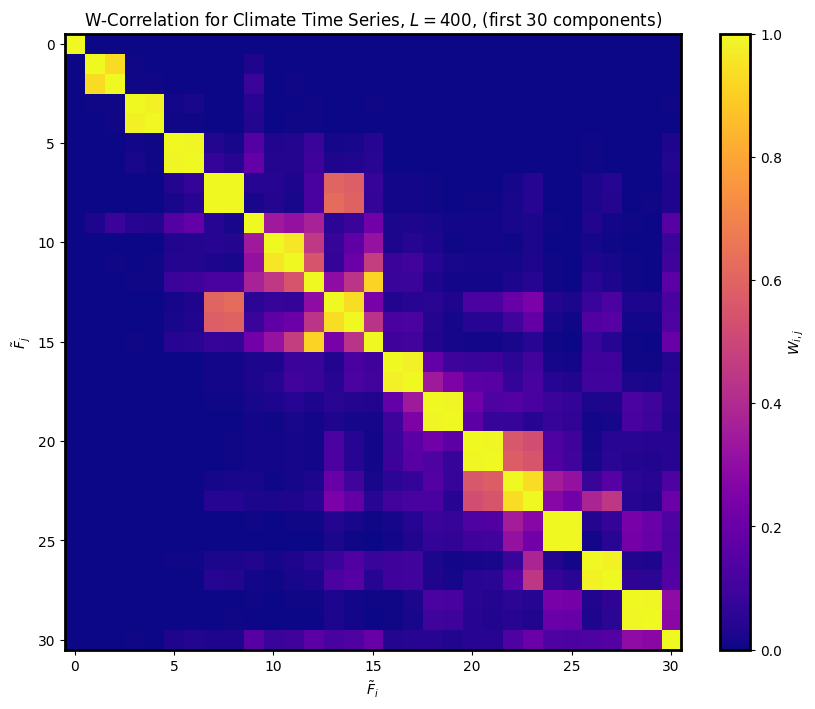

In [107]:
T_ssa = SSA(series, 400)
T_ssa.plot_wcorr(max = 30)
plt.title('W-Correlation for Climate Time Series, $L=400$, (first 30 components)')

In [108]:
# На графике видна связь между объединёнными компонентами

In [109]:
# Построим указанные компоненты

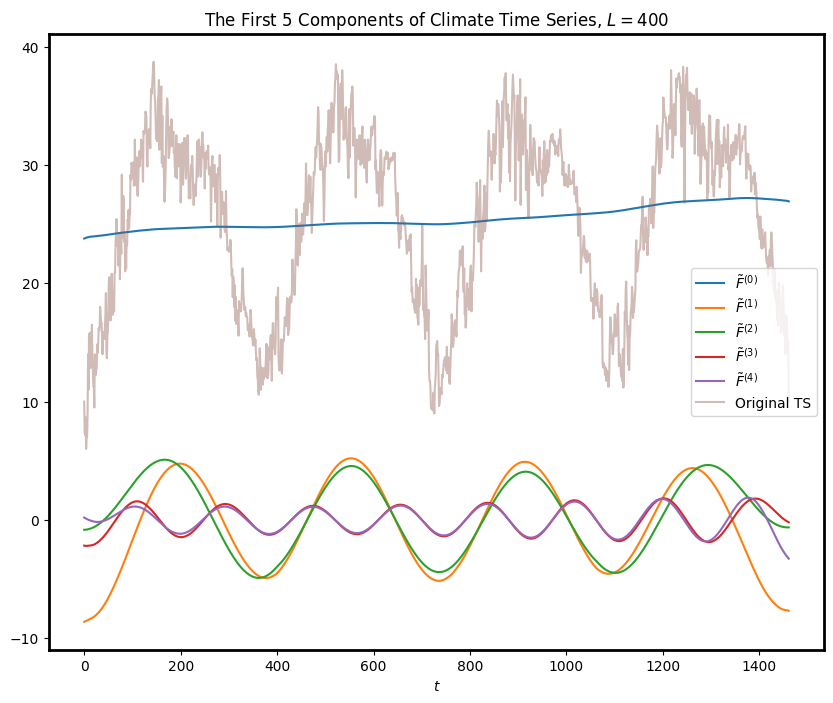

In [110]:
T_ssa.components_to_df(n=5).plot()
T_ssa.orig_TS.plot(alpha=0.4)
plt.title(r'The First 5 Components of Climate Time Series, $L=400$')
plt.xlabel(r'$t$')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(5)] + ['Original TS']
plt.legend(legend)

In [111]:
# Теперь сгруппируем и увеличим мастштаб

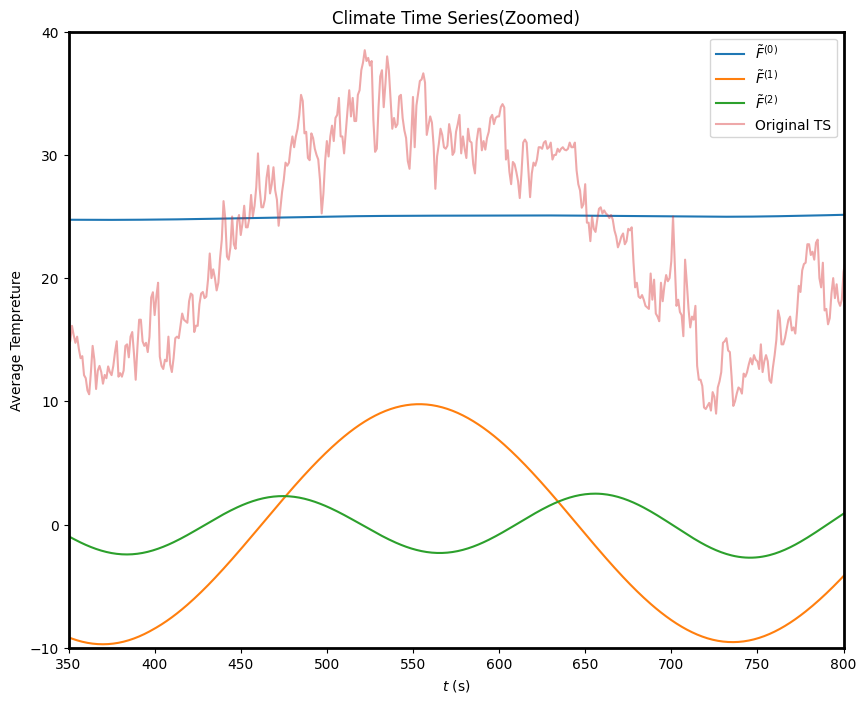

In [112]:
T_ssa.reconstruct(0).plot()
T_ssa.reconstruct([1,2]).plot()
T_ssa.reconstruct([3,4]).plot()
T_ssa.orig_TS.plot(alpha=0.4)
plt.title('Climate Time Series(Zoomed)')
plt.xlabel(r'$t$ (s)')
plt.ylabel('Average Tempreture')
plt.xlim(350,800)
plt.ylim(-10, 40)
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(3)] + ['Original TS']
plt.legend(legend);

In [113]:
# Поищем еще более высокочастотные периодичности:
# Согласно матрице корреляций, мы можем объединить еще F6-F9 с F11-16
# и F17 - F30

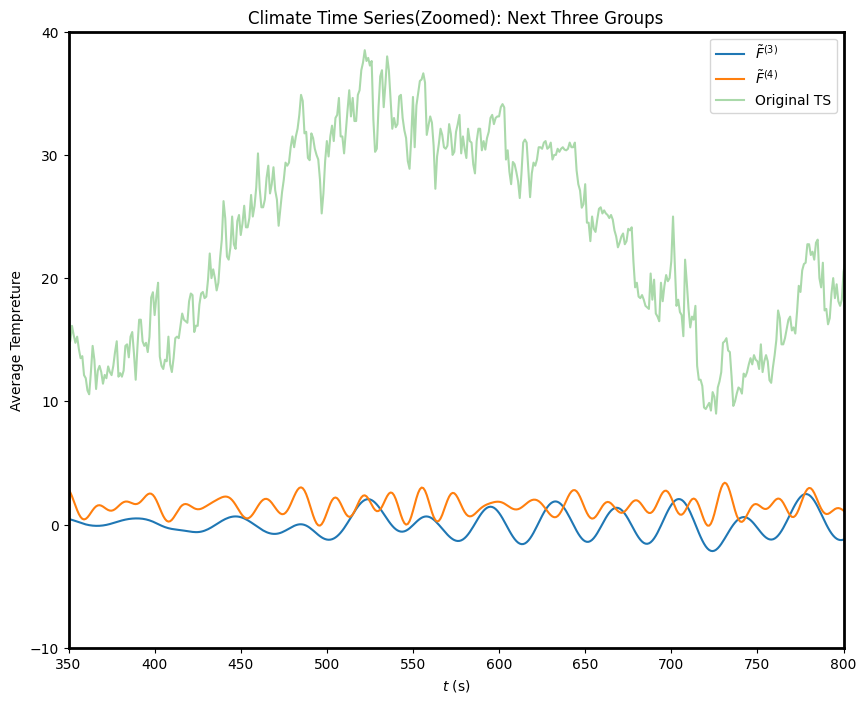

In [114]:
T_ssa.reconstruct([6,7,8,9,11,12,13,14,15,16]).plot()
(T_ssa.reconstruct([17,18,19,20,21,22,23,24,25,26,27,28,29,30]) + 1.5).plot() # Note: adding 1,5 to the series is for visualisation purposes only!
T_ssa.orig_TS.plot(alpha=0.4)
plt.title('Climate Time Series(Zoomed): Next Three Groups')
plt.xlabel(r'$t$ (s)')
plt.ylabel('Average Tempreture')
plt.xlim(350,800)
plt.ylim(-10, 40)
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(3,5)] + ['Original TS']
plt.legend(legend);

In [115]:
# Объединим первые 16 компонентов и посторим оставшиеся

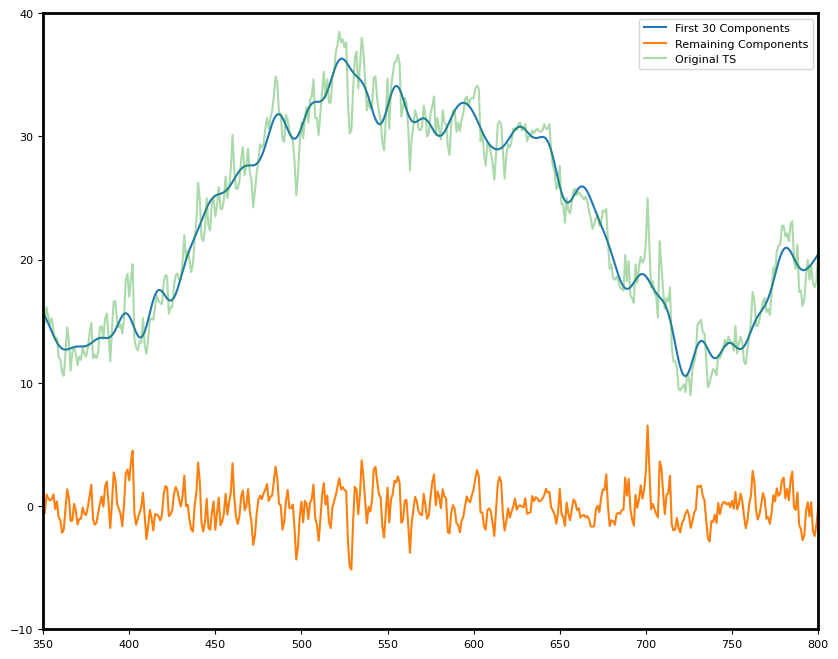

In [120]:
T_ssa.reconstruct(slice(0,30)).plot()
T_ssa.reconstruct(slice(30,400)).plot()
T_ssa.orig_TS.plot(alpha=0.4)
plt.ylim(-10, 40)
plt.xlim(350,800)
plt.legend(["First 30 Components", "Remaining Components", "Original TS"])

In [117]:
# Приведенный выше график показывает, что сумма первых 30 компонентов адекватно отражает основную,
# лежащую в основе периодичность временного ряда.
# Однако сумма оставшихся компонентов отражает пики исходного временного ряда более точно.